In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import explore as e
from importlib import reload
import wrangle as w
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.cluster import KMeans

In [67]:
reload(w)
df = w.wrangle_zillow(prop_row=.75,prop_col=.5)
df.groupby('outliers').agg('count')

,parcel_id,bath_count,bed_count,calc_bath_and_bed,calc_sqft,finished_sqft12,fips,fireplace_count,full_bath_count,garage_car_count,...,tax_value,assessment_year,land_value,tax_amount,census_tract_and_block,log_error,transaction_date,heating_system_desc,property_land_use_desc,log_error_outliers
outliers,,,,,,,,,,,,,,,,,,,,,
in_range,67436,67436,67436,67427,67429,65174,67436,67436,67427,67436,...,67435,67436,67435,67433,67254,67436,67436,43041,65303,67436
lower,3820,3820,3820,3816,3819,3357,3820,3820,3816,3820,...,3820,3820,3820,3819,3800,3820,3820,2705,3392,3820
upper,5277,5277,5277,5273,5274,4860,5277,5277,5273,5277,...,5277,5277,5277,5276,5259,5277,5277,3442,4895,5277


In [68]:
train, validate, test = w.tvt_split(df)

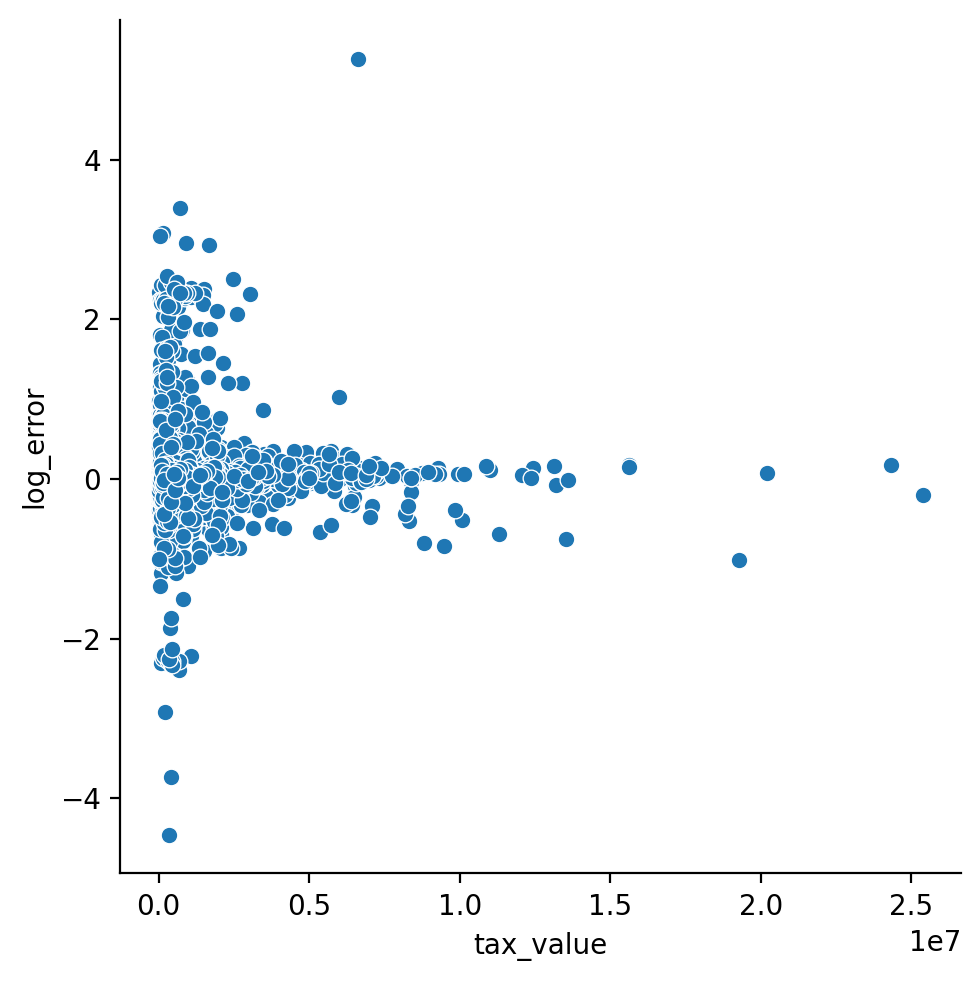

In [69]:

sns.relplot(data=train, x='tax_value', y='log_error')

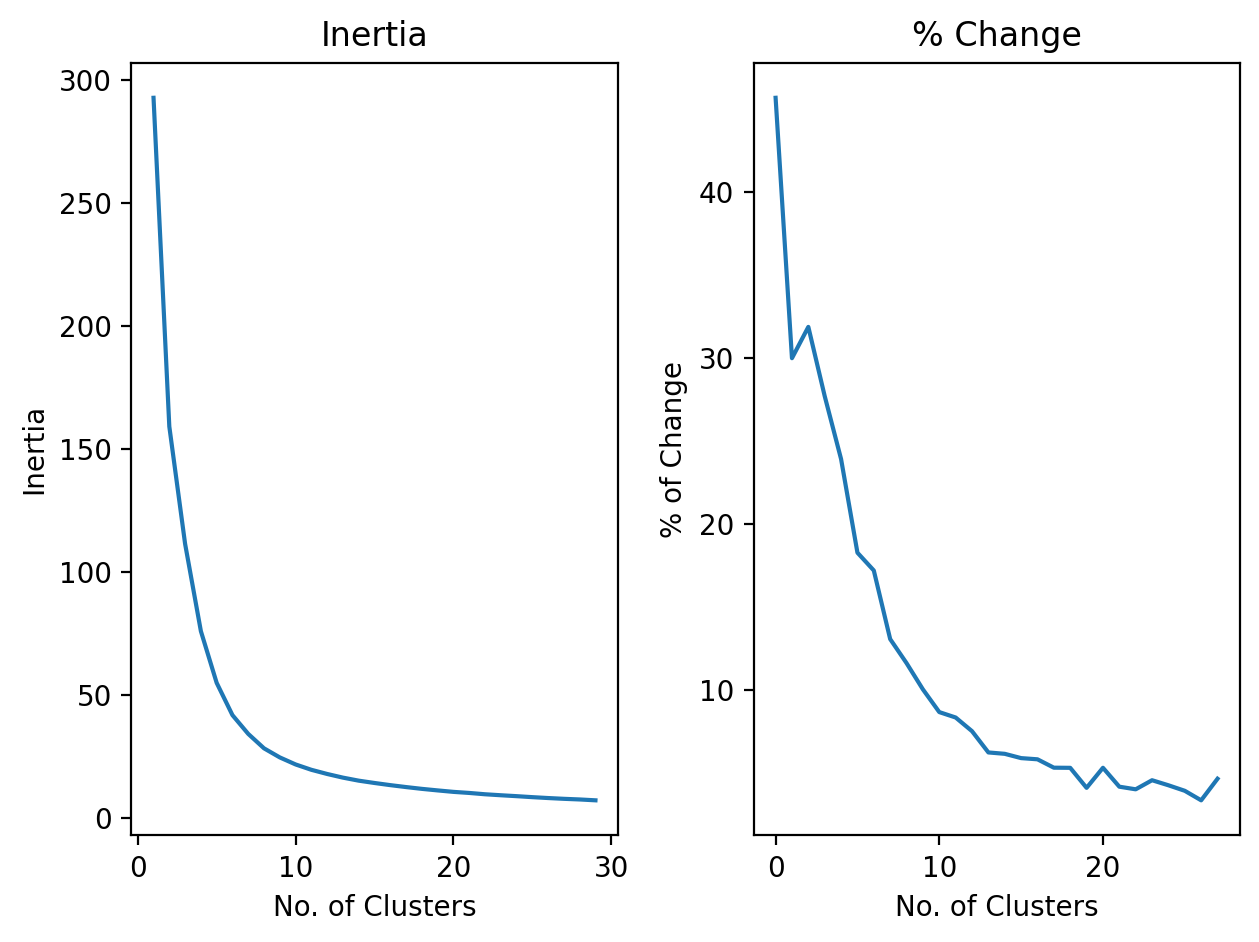

(5059, 2)

In [82]:
reload(e)
lower_tudes = w.scale(train[train.bound_group == 'lower'],['latitude','longitude'])

(9097, 35)

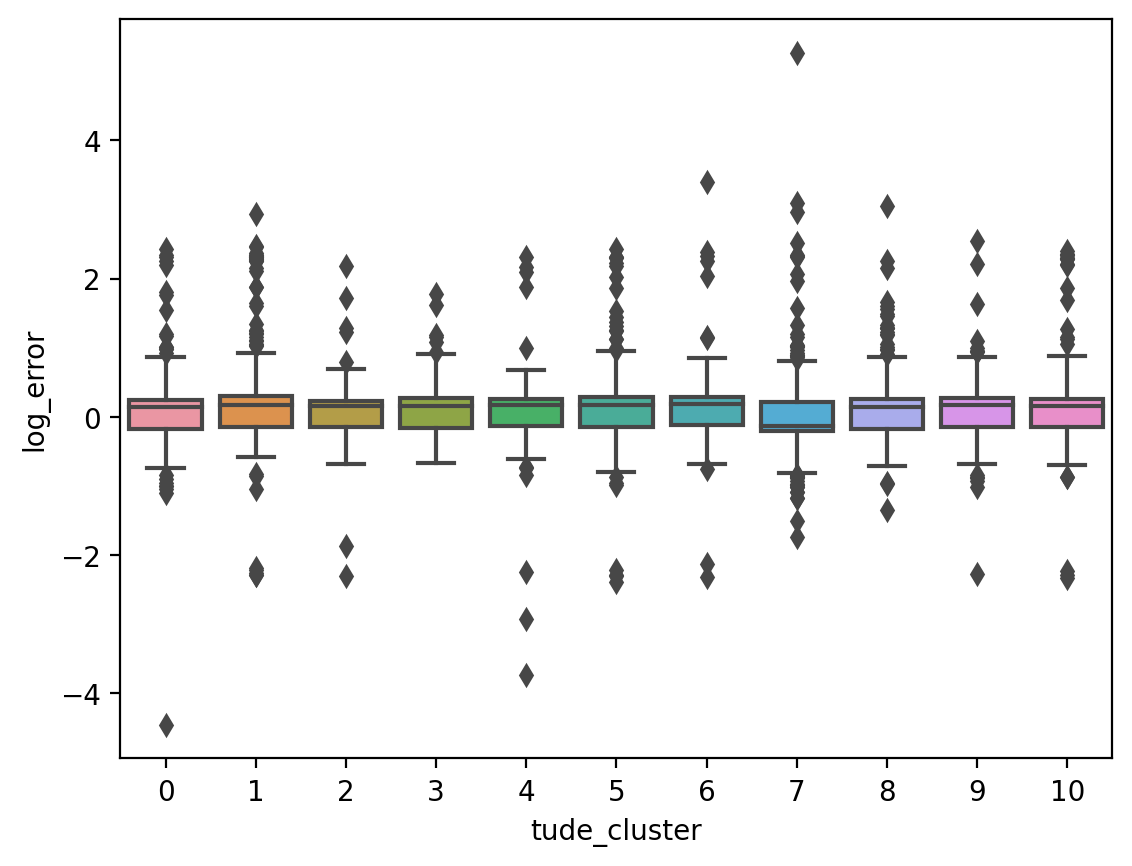

In [81]:
kmeans = KMeans(11)
kmeans.fit(scaled_tudes)
scaled_tudes['tude_cluster'] = kmeans.predict(scaled_tudes)
scaled_tudes['log_error'] = train[train.outliers !='in_range'].log_error
sns.boxplot(data=scaled_tudes,y='log_error',x='tude_cluster')
df[df.outliers != 'in_range'].shape

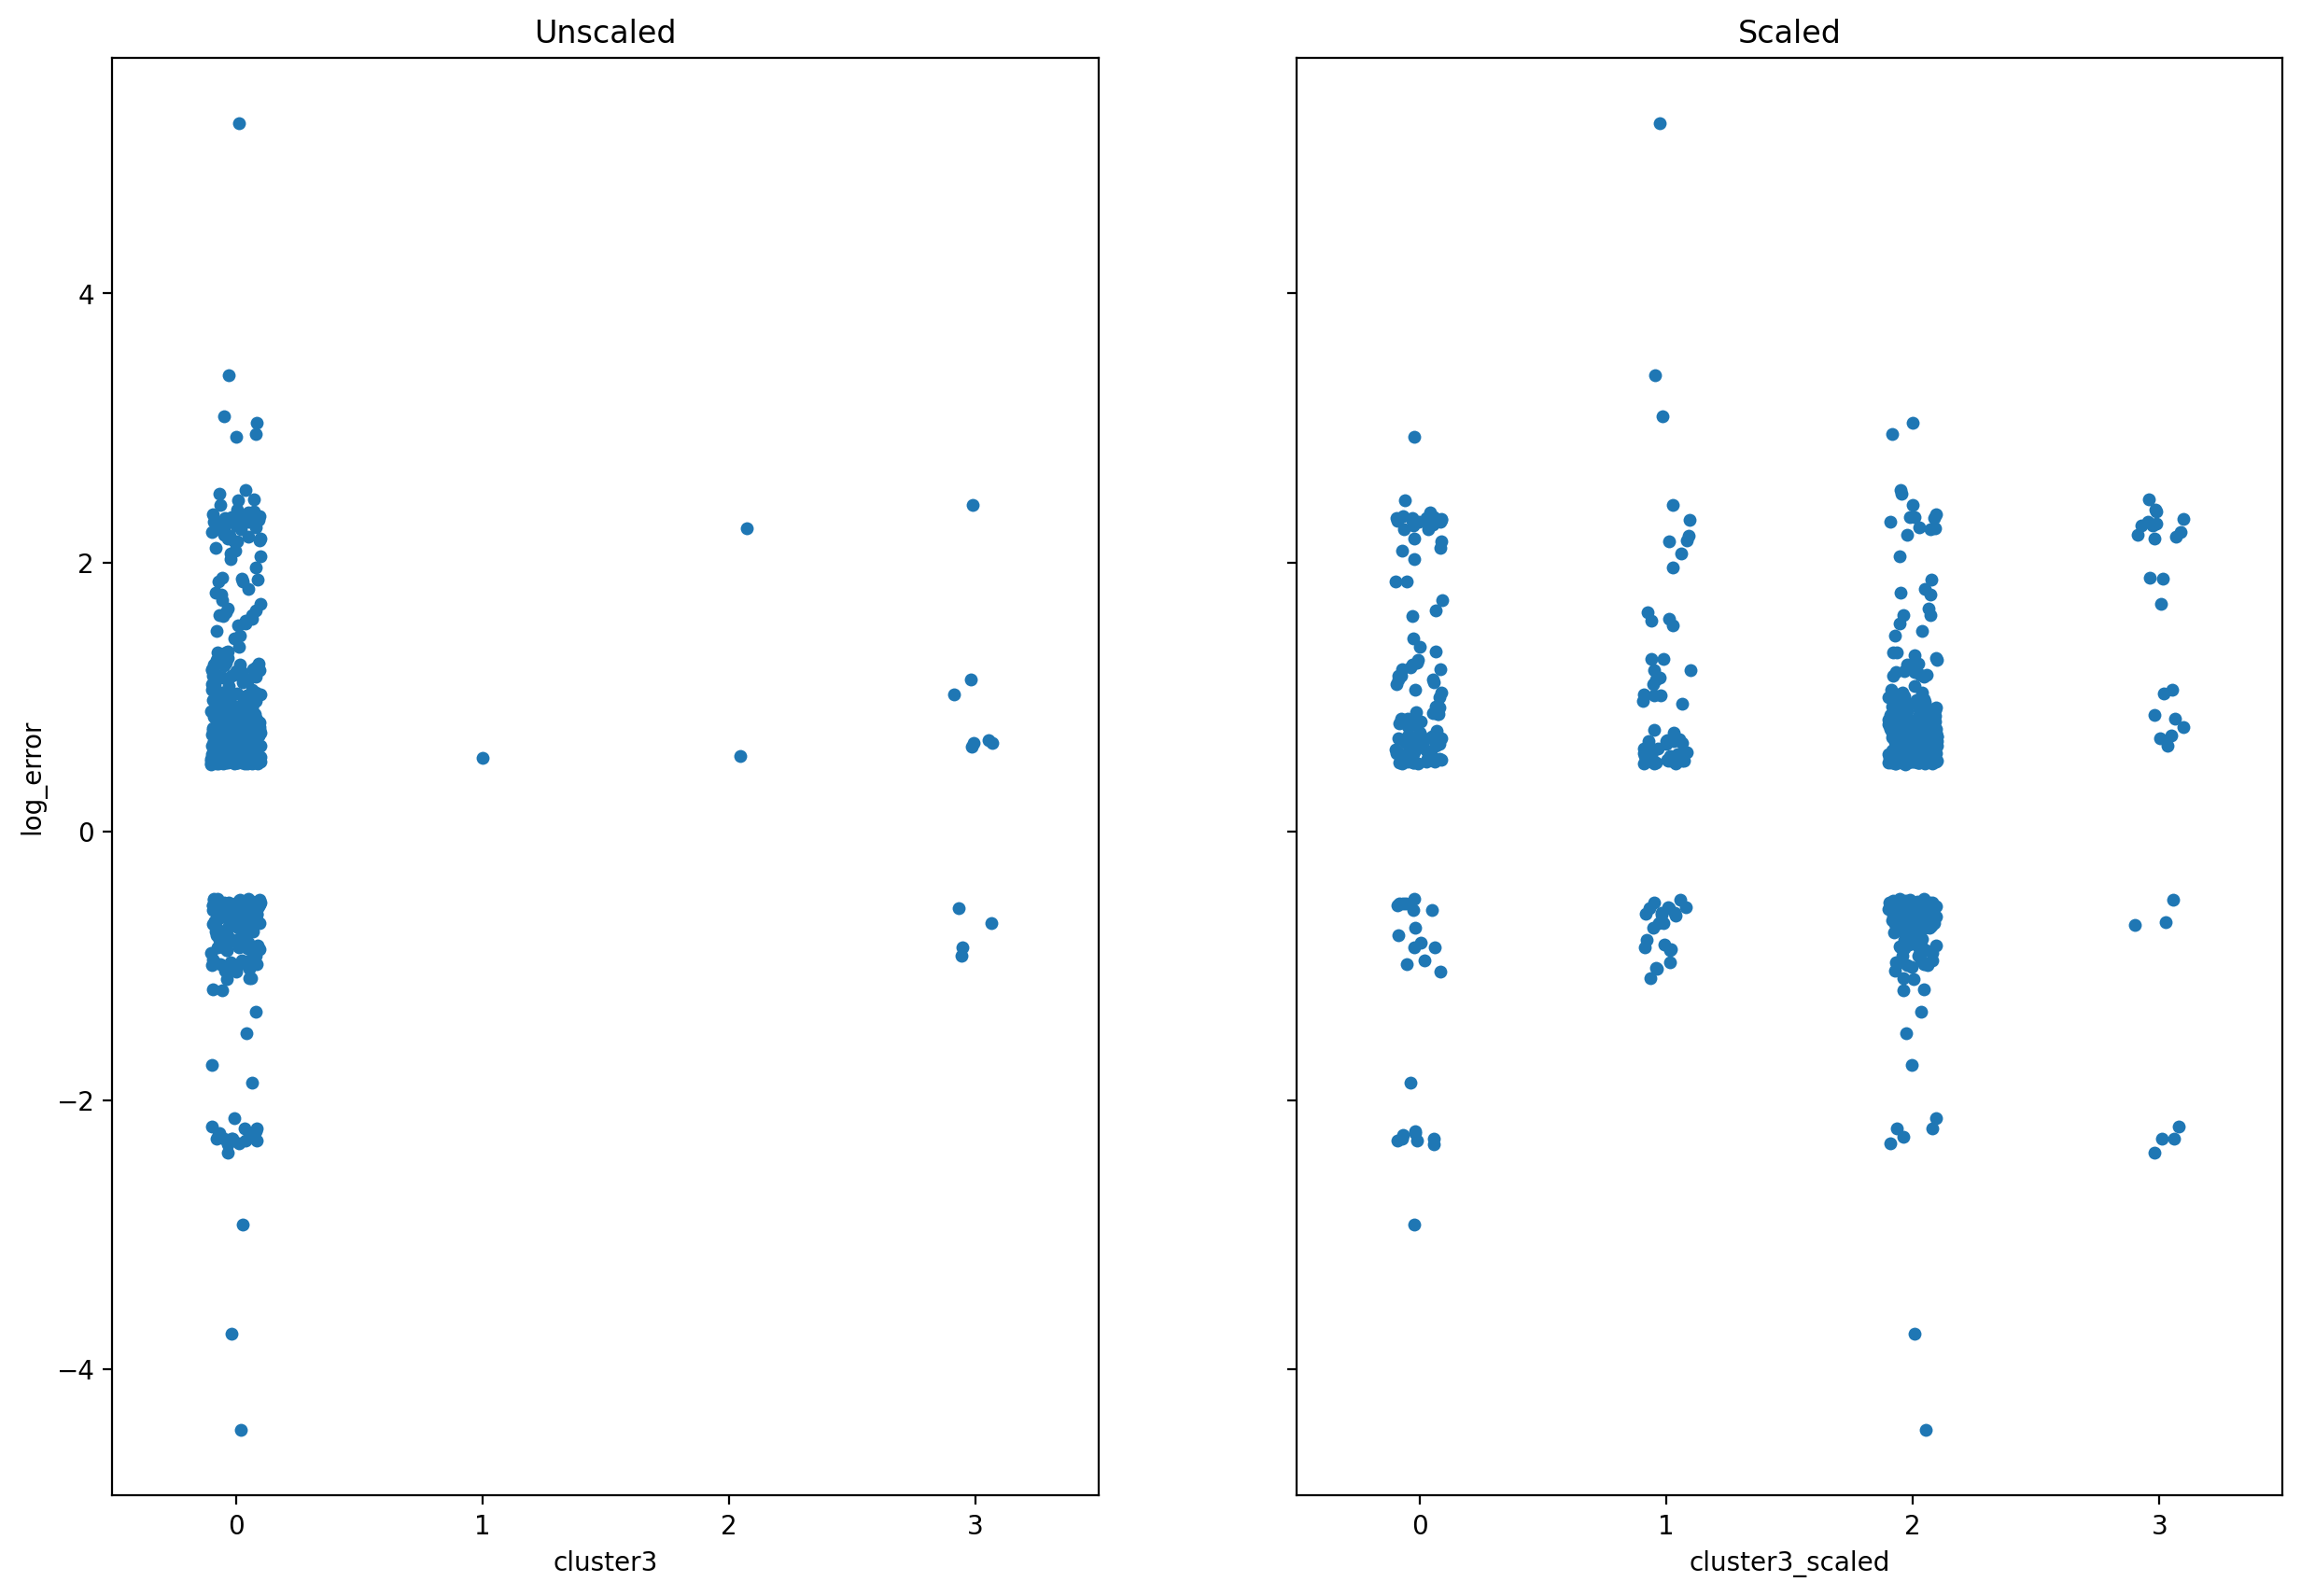

In [83]:
reload(e)
bound = .5
bound_train = train[(train.log_error > bound) | (train.log_error < (0-bound))]
e.viz_for_Q3(bound_train)